In [8]:
import numpy as np
import librosa
import soundfile as sf

config = {
            'noise_estimation_method': 'vad_based',  # Phương pháp ước tính nhiễu
            'smoothing_constant': 0.98,              # Hằng số làm mịn
            'min_gain': 0.1,                         # Gain tối thiểu
            'max_gain': 3.0,                         # Gain tối đa
            'frequency_smoothing': 2 ,                # Làm mịn tần số
            'snr_floor_db': -20                      # Sàn SNR (dB)
        }
y, sr = librosa.load("20250723_104006_03_dsp_spectral_subtracted.wav", sr=None)
D_full = librosa.stft(y)
D_vocals, D_crowd = librosa.decompose.hpss(D_full, margin=1.0)
magnitude = np.abs(D_full)
phase = np.angle(D_full)
signal_psd = magnitude**2
noise_psd = np.mean(np.abs(D_crowd)**2, axis=1, keepdims=True)
smoothing_constant = config['smoothing_constant']
smoothed = np.zeros_like(noise_psd)
smoothed[:, 0] = noise_psd[:, 0]
        
for i in range(1, noise_psd.shape[1]):
    smoothed[:, i] = smoothing_constant * smoothed[:, i-1] + \
(1 - smoothing_constant) * noise_psd[:, i]
snr_linear = signal_psd / (smoothed + 1e-10)
snr_db = 10 * np.log10(snr_linear)
snr_db = np.maximum(snr_db, config['snr_floor_db'])
snr_linear = 10**(snr_db / 10)
wiener_gain = snr_linear / (snr_linear + 1)
wiener_gain = np.clip(wiener_gain, config['min_gain'], config['max_gain'])
smoothed_gain = np.zeros_like(wiener_gain)
        
for i in range(wiener_gain.shape[1]):
    frame = wiener_gain[:, i]
    kernel = np.ones(config['frequency_smoothing']) / config['frequency_smoothing']
    smoothed_gain[:, i] = np.convolve(frame, kernel, mode='same')
# Áp dụng bộ lọc
filtered_magnitude = magnitude * smoothed_gain   
filtered_magnitude = filtered_magnitude * np.exp(1j * phase)
final = librosa.istft(filtered_magnitude, length=len(y))
sf.write("filter.wav", final, sr)

In [9]:
# get f0 track
f0_track = []
magnitude_filtered = np.abs(filtered_magnitude)
# Xử lý từng frame
for frame_idx in range(magnitude_filtered.shape[1]):
    frame = magnitude_filtered[:, frame_idx]
            
    # Phương pháp autocorrelation
    autocorr = np.correlate(frame, frame, mode='full')
    autocorr = autocorr[len(autocorr)//2:]  # Lấy phần dương
            
    # Tìm peak (bỏ qua DC component)
    min_period = int(sr / 1000)  # Tần số tối đa 1000 Hz
    max_period = int(sr / 80)    # Tần số tối thiểu 80 Hz
            
    if len(autocorr) > max_period:
        # Tìm peak trong khoảng hợp lệ
        peak_idx = np.argmax(autocorr[min_period:max_period]) + min_period
        f0 = sr / peak_idx if peak_idx > 0 else 0
    else:
        f0 = 0
            
    f0_track.append(f0)
        
f0_track = np.array(f0_track)

In [ ]:
# Harmonic enhancement
config = {
    'harmonics_count': 8,  # Số lượng âm hài cần xử lý
    'harmonic_threshold': 0.3,  # Ngưỡng cường độ âm hài
    'enhancement_factor': 2,  # Hệ số tăng cường
}

n_fft = (D_full.shape[0] - 1) * 2

def calculate_harmonic_strength(magnitude_frame, bin_idx, window_size=3):
        start_idx = max(0, bin_idx - window_size)
        end_idx = min(len(magnitude_frame), bin_idx + window_size + 1)
        
        local_region = magnitude_frame[start_idx:end_idx]
        peak_value = magnitude_frame[bin_idx]
        
        # Cường độ âm hài = peak / (trung bình xung quanh)
        surrounding_mean = (np.sum(local_region) - peak_value) / (len(local_region) - 1)
        
        return peak_value / (surrounding_mean + 1e-10)
stft_matrix = filtered_magnitude
magnitude = np.abs(stft_matrix)
phase = np.angle(stft_matrix)
        
# Tạo bản sao để sửa đổi
enhanced_magnitude = magnitude.copy()
        
# Xử lý từng frame
for frame_idx in range(magnitude.shape[1]):
    f0 = f0_track[frame_idx]
            
    if f0 > 0:  # Nếu phát hiện được F0 hợp lệ
        # Tính toán vị trí các âm hài
        harmonics = [f0 * (i + 1) for i in range(config['harmonics_count'])]
                
        # Tìm bin tần số cho từng âm hài
        for harmonic_freq in harmonics:
            if harmonic_freq < sr / 2:  # Trong dải Nyquist
                # Tìm bin tần số gần nhất
                bin_idx = int(harmonic_freq * n_fft / sr)
                        
                if bin_idx < len(magnitude):
                # Tính cường độ âm hài
                    harmonic_strength = calculate_harmonic_strength(
                        magnitude[:, frame_idx], bin_idx, window_size=3
                    )
                            
                    # Cải thiện nếu trên ngưỡng
                    if harmonic_strength > config['harmonic_threshold']:
                        enhanced_magnitude[bin_idx, frame_idx] *= config['enhancement_factor']
        
# Tái tạo STFT với phase gốc
enhanced_stft = enhanced_magnitude * np.exp(1j * phase)
harmonic_enhanced = librosa.istft(enhanced_stft, length=len(y))
sf.write("harmonic_enhanced.wav", harmonic_enhanced, sr)

In [17]:
config = {
    'rms_window_size': 1024,      # Kích thước cửa sổ RMS
    'smoothing_factor': 0.95,      # Hệ số làm mịn
    'threshold_db': -35,          # Ngưỡng cổng (dB) - **BỔ SUNG**
    'attack_time_ms': 1,          # Thời gian attack (ms) - **BỔ SUNG**
    'release_time_ms': 100,       # Thời gian release (ms) - **BỔ SUNG**
    'hold_time_ms': 10 
}
audio = harmonic_enhanced
def calculate_rms_envelope(audio, window_size):
    hop_size = window_size // 4  # Chồng lấp 75%
    rms_values = []
    # Tính RMS cho từng cửa sổ
    for i in range(0, len(audio) - window_size, hop_size):
        window = audio[i:i + window_size]
        rms = np.sqrt(np.mean(window**2))  # Root Mean Square
        rms_values.append(rms)
    # Nội suy về độ dài gốc
    if len(rms_values) > 0:
        rms_envelope = np.interp(
            np.arange(len(audio)),                          # Điểm nội suy
            np.arange(0, len(audio), hop_size)[:len(rms_values)],  # Điểm gốc
            rms_values                                       # Giá trị RMS
        )
    else:
        rms_envelope = np.zeros(len(audio))
        
    return rms_envelope
def generate_gate_control(rms_db):
    # Xác định trạng thái cổng dựa trên ngưỡng
    gate_state = rms_db > config['threshold_db']
    # Tính các hằng số thời gian theo samples
    attack_samples = int(config['attack_time_ms'] * sr / 1000)
    release_samples = int(config['release_time_ms'] * sr / 1000)
    hold_samples = int(config['hold_time_ms'] * sr / 1000)
        
    # Máy trạng thái cho điều khiển cổng
    gate_control = np.zeros_like(rms_db)
    current_state = 0  # 0: đóng, 1: đang mở, 2: mở, 3: đang đóng
    hold_counter = 0
    ramp_position = 0
    for i in range(len(rms_db)):
        if gate_state[i]:  # Tín hiệu trên ngưỡng
            if current_state == 0:  # Bắt đầu mở cổng
                current_state = 1
                ramp_position = 0
            elif current_state == 1:  # Tiếp tục mở cổng
                ramp_position += 1
                if ramp_position >= attack_samples:
                    current_state = 2  # Mở hoàn toàn
            elif current_state == 3:  # Dừng đóng cổng
                current_state = 2
            hold_counter = hold_samples  # Reset hold counter
                
        else:  # Tín hiệu dưới ngưỡng
            if current_state == 2:  # Bắt đầu hold
                hold_counter -= 1
                if hold_counter <= 0:
                    current_state = 3  # Bắt đầu đóng cổng
                    ramp_position = 0
            elif current_state == 3:  # Tiếp tục đóng cổng
                ramp_position += 1
                if ramp_position >= release_samples:
                    current_state = 0  # Đóng hoàn toàn
            
        # Tính giá trị cổng
        if current_state == 0:  # Đóng
            gate_control[i] = 0
        elif current_state == 1:  # Đang mở
            gate_control[i] = ramp_position / attack_samples if attack_samples > 0 else 1
        elif current_state == 2:  # Mở
            gate_control[i] = 1
        elif current_state == 3:  # Đang đóng
            gate_control[i] = 1 - (ramp_position / release_samples) if release_samples > 0 else 0
        
    return gate_control
# Tính envelope RMS
rms_envelope = calculate_rms_envelope(harmonic_enhanced, config['rms_window_size'])
# Chuyển đổi sang dB
rms_db = 20 * np.log10(rms_envelope + 1e-10)
# Tạo tín hiệu điều khiển cổng
gate_control = generate_gate_control(rms_db)
# Áp dụng cổng với làm mịn
smoothing_factor = config['smoothing_factor']
smoothed_gate = np.zeros_like(gate_control)
smoothed_gate[0] = gate_control[0]
# Làm mịn tín hiệu điều khiển
for i in range(1, len(gate_control)):
    smoothed_gate[i] = smoothing_factor * smoothed_gate[i-1] + \
        (1 - smoothing_factor) * gate_control[i]
# Áp dụng cổng lên tín hiệu
gated_audio = audio * smoothed_gate
sf.write("gated_audio.wav", gated_audio, sr)

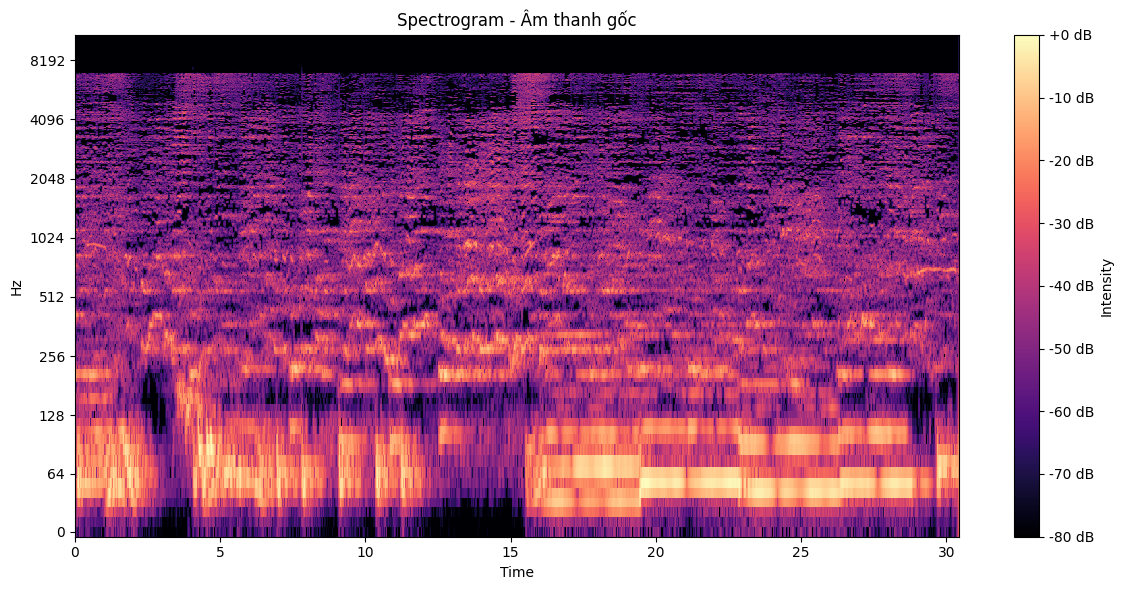

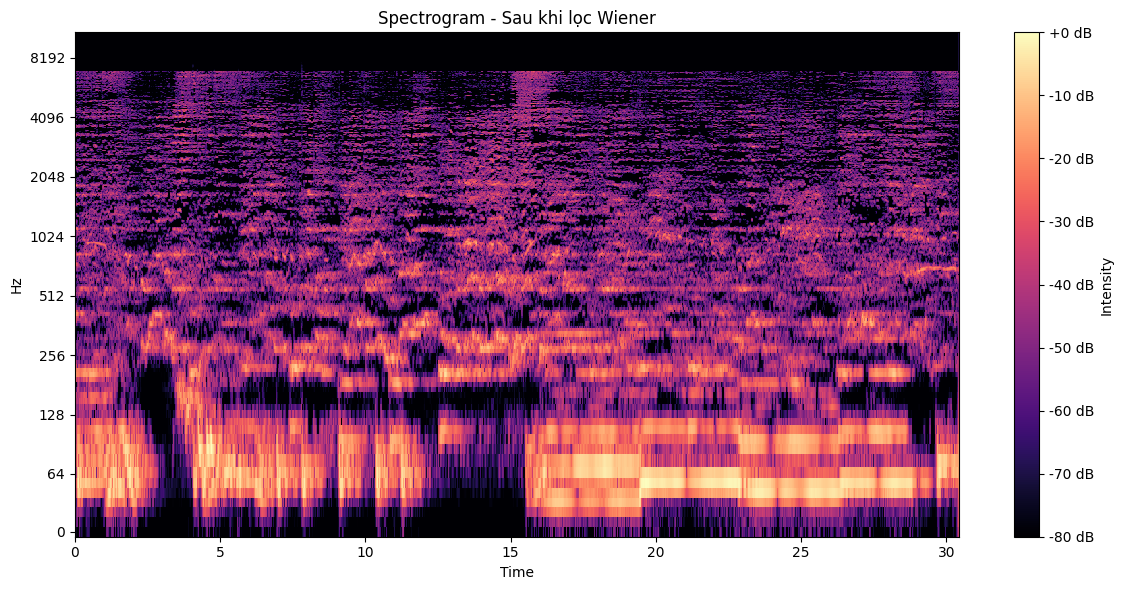

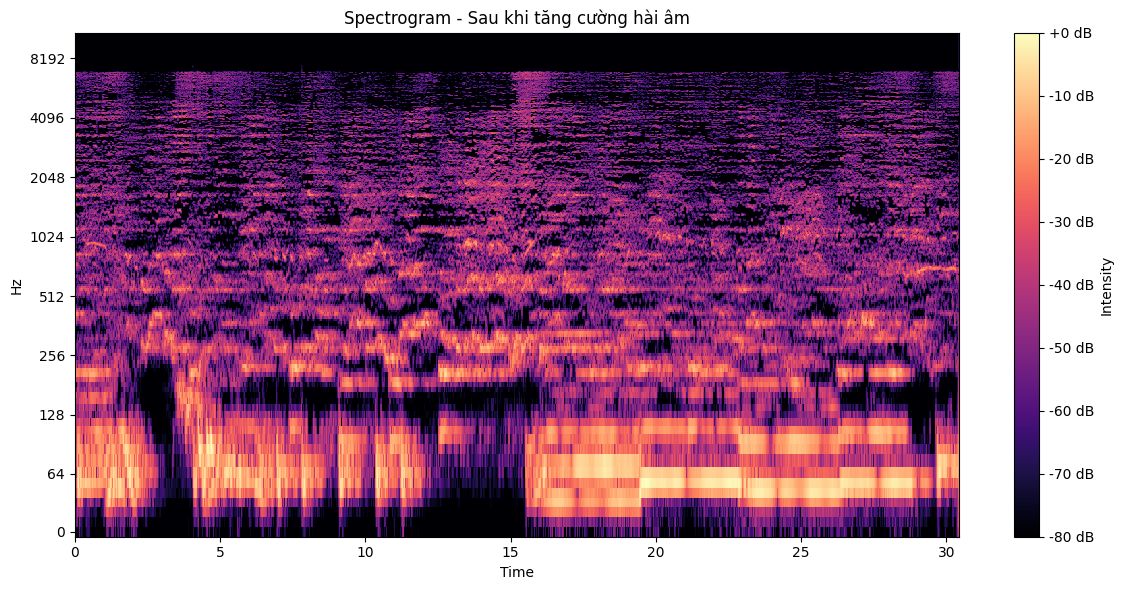

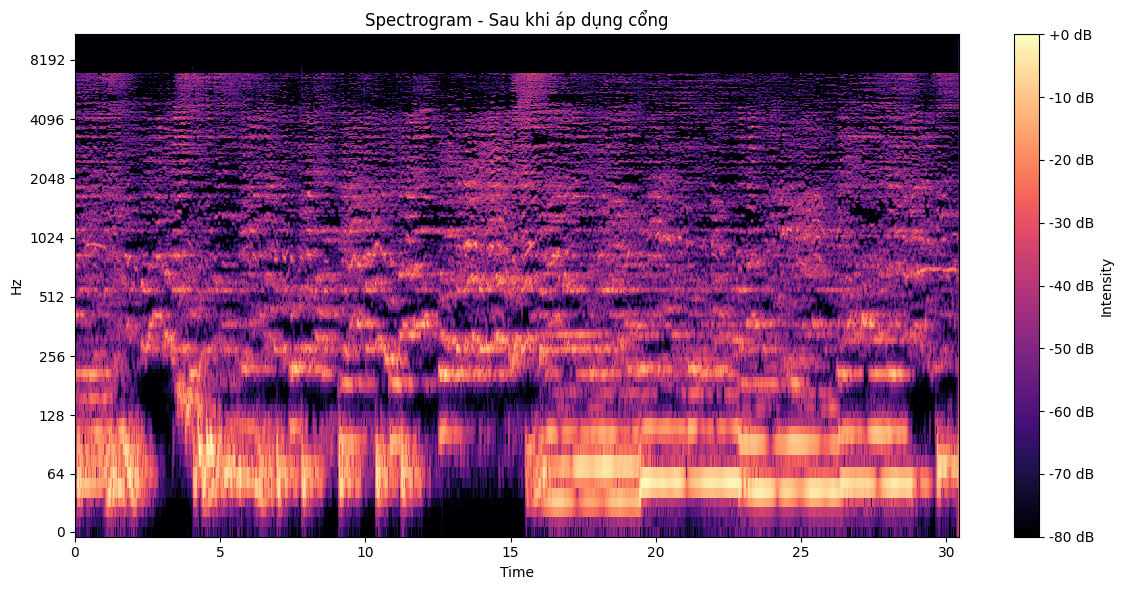

In [18]:
import matplotlib.pyplot as plt
import librosa.display


# Hàm tiện ích để vẽ spectrogram
def plot_spectrogram(stft_matrix, sr, title):
    """Vẽ biểu đồ spectrogram từ ma trận STFT phức."""
    magnitude = np.abs(stft_matrix)
    db_magnitude = librosa.amplitude_to_db(magnitude, ref=np.max)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    img = librosa.display.specshow(db_magnitude, sr=sr, x_axis='time', y_axis='log', ax=ax)
    fig.colorbar(img, ax=ax, format='%+2.0f dB', label='Intensity')
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

# 1. Biểu đồ của âm thanh đầu vào (sau khi đã qua spectral subtraction)
plot_spectrogram(D_full, sr, 'Spectrogram - Âm thanh gốc')

# 2. Biểu đồ sau khi qua bộ lọc Wiener
plot_spectrogram(filtered_magnitude, sr, 'Spectrogram - Sau khi lọc Wiener')

# 3. Biểu đồ sau khi tăng cường hài âm
plot_spectrogram(enhanced_stft, sr, 'Spectrogram - Sau khi tăng cường hài âm')
# 4. Biểu đồ sau khi áp dụng cổng
gated_stft = librosa.stft(gated_audio)
plot_spectrogram(gated_stft, sr, 'Spectrogram - Sau khi áp dụng cổng')

### Phân tích biểu đồ:

#    **Trục hoành (X):** Thời gian.
#    **Trục tung (Y):** Tần số (từ thấp đến cao).
#    **Màu sắc:** Cường độ âm thanh. Màu càng "nóng" (vàng, đỏ) thì cường độ tại tần số và thời điểm đó càng lớn.

# Khi nhìn vào các biểu đồ, hãy chú ý:
# 1.  **Trong biểu đồ "Âm thanh gốc"**: Tìm các dải tần số có màu sắc sáng, liên tục theo chiều ngang. Đây thường là nhiễu nền (tiếng hò hét, tiếng ù).
# 2.  **Trong biểu đồ "Sau khi lọc Wiener"**: So sánh với biểu đồ gốc. Các dải nhiễu nền đó phải mờ đi đáng kể (màu chuyển sang xanh, tím). Các đường nét đứt quãng, thay đổi theo thời gian (giọng hát) nên được giữ lại.
# 3.  **Trong biểu đồ "Sau khi tăng cường hài âm"**: So sánh với biểu đồ thứ hai. Bạn sẽ thấy các đường nét của giọng hát trở nên rõ ràng và "dày" hơn một chút do các hài âm được khuếch đại.// filepath: d:\DSP-present\fancam_noise_reduction\test_config.ipynb
